<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Откроем-и-изучим-файл-с-данными" data-toc-modified-id="Откроем-и-изучим-файл-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Откроем и изучим файл с данными</a></span><li><span><a href="#Разобьем-данные-на-выборки" data-toc-modified-id="Разобьем-данные-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разобьем данные на выборки</a></span></li><li><span><a href="#Исследуем-модели" data-toc-modified-id="Исследуем-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследуем модели</a></span></li><li><span><a href="#Проверим-модель-на-тестовой-выборке" data-toc-modified-id="Проверим-модель-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверим модель на тестовой выборке</a></span></li><li><span><a href="#Проверим-модели-на-адекватность" data-toc-modified-id="Проверим-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверим модели на адекватность</a></span></li><li><span>

# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Наша задача - построить модель с максимально большим значением *accuracy*. Для решения задачи нужно довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке самостоятельно.

# Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откроем и изучим файл с данными

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import dump
import seaborn as sns
from sklearn.model_selection import GridSearchCV
df = pd.read_csv('//content/5_users_behavior.csv')

In [ ]:
df.head() #изучим первые пять строк датасета

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
df.info() #выведем на экран общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
df.isnull().sum() # на всякий случай проверим есть ли пропуски

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


Проверим корреляцию данных при помощи метода, `sns.pairplot`

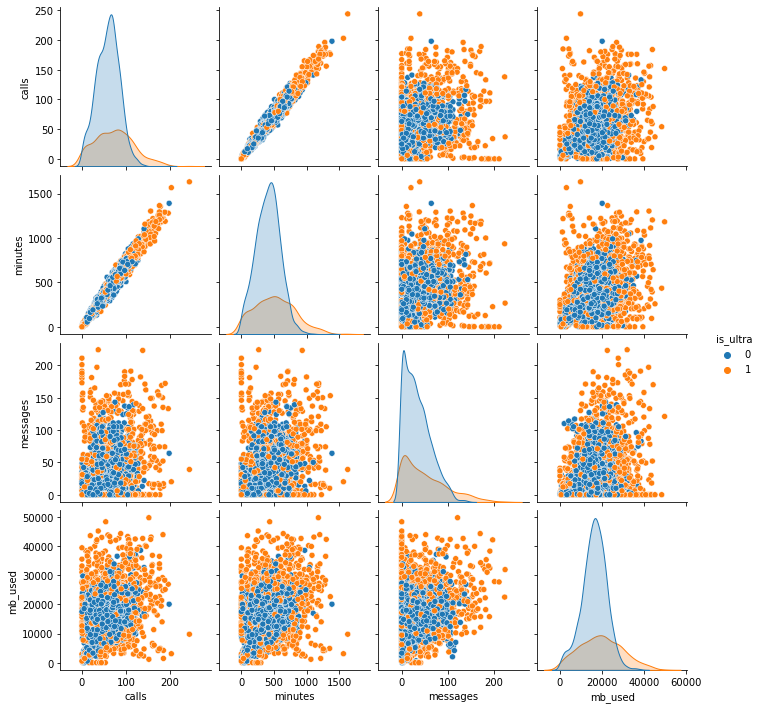

In [ ]:
sns.pairplot(df, hue='is_ultra');

<div class="alert alert-block alert-warning">
Из графиков можно отметить сильную корреляцию между количеством звонков и общей продолжительностью разговоров, что является логичным - чем больше звонков абонент сделал, тем больше минут из тарифа или сверх тарифа он потратил.
</div>

## Разобьем данные на выборки

In [ ]:
df_1, df_test = train_test_split(df,test_size=0.2,random_state=12345) # выделим тестовую выборку из общего датасета
df_train, df_valid = \
train_test_split(df_1,test_size = 0.25,\
random_state=12345) #поделим остаток, полученный после выделения тестовой выборки на 2 части:тренировочную и валидационную выборки

In [ ]:
print (f'Доля тренировочной выборки:{round(len(df_train)/len(df)*100)}%') #проверим результат разделения
print (f'Доля тестовой выборки:{round(len(df_test)/len(df)*100)}%')
print (f'Доля валидационной выборки:{round(len(df_valid)/len(df)*100)}%')

Доля тренировочной выборки:60%
Доля тестовой выборки:20%
Доля валидационной выборки:20%


In [ ]:
features_train = df_train.drop(['is_ultra'],axis = 1) #задаем обучающий набор данных
target_train = df_train['is_ultra']
features_test = df_test.drop(['is_ultra'],axis = 1) #задаем тестовый набор данных
target_test = df_test['is_ultra']
features_valid = df_valid.drop(['is_ultra'],axis = 1) #задаем валидационный набор данных
target_valid = df_valid['is_ultra']


## Исследуем модели

Исследуем гиперпараметры для дерева решений. Основной гиперпараметр - это max-depth, определяюший количество ветвлений. Определим какое значение данного гиперпараметра обеспечит максимальную долю правильных ответов.

In [ ]:
for depth in range(1,6):
    model = DecisionTreeClassifier( random_state=12345,max_depth=depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid)) 

max_depth = 1 : 0.7387247278382582
max_depth = 2 : 0.7573872472783826
max_depth = 3 : 0.7651632970451011
max_depth = 4 : 0.7636080870917574
max_depth = 5 : 0.7589424572317263


Чем больше ветвлений, тем точнее прогноз. Значение max_depth равное `3`дает наибольшую точность прогноза - 0.7651632970451011 или почти 77% правильных ответов из всех возможных.

Теперь переберем гиперпараметры для случайного леса. Определим какой максимальной точности мы сможем добиться перебирая количестов дерьевьев в лесу ( гиперпараметр n_estimators) от 1 до 10.


In [ ]:
best_model = None
best_result = 0
n=0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train,target_train) 
    result = model.score(features_valid,target_valid) 
    if result > best_result:
        best_model = model
        best_result = result
        n=est
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print ( "Количество деревьев:",n )

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566
Количество деревьев: 10


Для случайного леса лучше всего выбрать гиперпараметр n_estimators равный 10, при этом точность прогноза составит почти 79% (0.7884914463452566).

Последний алгоритм обработки данных, который мы рассмотрим для целей обучения модели - логистическая регрессия.

In [ ]:
model = LogisticRegression(random_state = 12345, solver ='lbfgs', max_iter=1000)
model.fit(features_train,target_train)
model.predict(features_valid)
model.score(features_valid,target_valid)
dump(model, 'model_9_1.joblib')
print ("Accuracy:",model.score(features_valid,target_valid) )

Accuracy: 0.7262830482115086


Самая низкая точность из трёх исследованных алгоритмов у логистической регрессии - чуть больше 72% правильных ответов получим при использовании этого алгоритма.

Дополнительно решим задачу инструментом GridSearchCv. 


In [ ]:
clf = RandomForestClassifier() 

<div class="alert alert-block alert-warning">
Отдельно создаем словарик, в который вписываем параметры, которые будем прогонять GridSearch’ем. Для примера будем использовать следующие параметры:

n_estimators – число деревьев в лесу. Оно будет изменяться от 10 до 50 с шагом 10

max_depth – глубина дерева. Она будет изменяться от 1 до 12 с шагом в 2

min_samples_leaf – минимальное число образцов в листах. Оно будет изменяться от 1 до 7

min_samples_leaf – минимальное число образцов для сплита. Оно будет изменяться от 2 до 9.
    </div>

In [ ]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [ ]:
grid = GridSearchCV(clf, parametrs, cv=5) #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 7,
 'min_samples_split': 8,
 'n_estimators': 40}

## Проверим модель на тестовой выборке

Исходя из сравнения доли правильных ответов в зависимости от задаваемых параметров, алгоритм обучения "случайный лес" гарантирует наибольшую долю правильных ответов. У него есть свои минусы, он не такой быстрый, как решающее дерево или логистическая регрессия, но на имеющемся объеме данных, скорость работы для нас не будет являться решающим параметром. Остановимся на алгоритме "случайный лес" с количеством деревьев равным `10` для проверки модели на тестовой выборке.

In [ ]:
best_model.fit(features_train,target_train) 
predictions_test = best_model.predict(features_test)
accuracy_score(target_test, predictions_test)

0.7869362363919129

<div class="alert alert-block alert-warning">
Посмотрим как изменится доля правильных ответов при использовании модели с лучшими параметрами, определенными при помощи GridSearchCV.
</div>

In [ ]:
the_very_best_model = RandomForestClassifier(n_estimators=30,max_depth=11,min_samples_leaf=6,min_samples_split=2)
the_very_best_model.fit(features_train,target_train) 
predictions_test = the_very_best_model.predict(features_test)
accuracy_score(target_test, predictions_test)

0.7947122861586314

<div class="alert alert-block alert-warning">
Доля правильных ответов при использовании новых параметров увеличилась: 80,1% vs 78,7%. Правда ждать ответа теперь приходится значительно дольше :)
</div>

Доля правильных ответов почти совпадает с результатом, полученным для валидационной выборки и её размер больше 75%, заданных по условию задачи. Делаем вывод, что мы сделали правильный выбор и можем использовать данную модель для выбора оптимального тарифа по заданным параметрам количества звонков, расхода минут разговора, сообщений, расхода мегабайт траффика.

## Проверим модели на адекватность

Рассчитаем точность предсказания при использовании DummyClassifier.

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')
predictions_dummy = dummy_clf.predict(features_test)
dummy_clf.score(target_test,predictions_dummy )


0.5894245723172629

Доля правильных ответов в случае использования DummyClassifier составит около 60%, что меньше 78,7%, которые показывает использование выбранного нами алгоритма. Обученная нами модель является более адекватной, поскольку она даст больше правильных ответов.

Модель с необходимой метрикой качества построена.

